# Zaczytanie Bibliotek

In [1]:
#Zaczytanie wszyskich bibliotek wykorzystanych w projekcie
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
import time
from sklearn import  metrics

# Przygotowanie danych

Pliki zawierają dane o recenzjach produktów, filmów i restauracji zebranych na 3 stronach internetowych. Recenzje mogą mieć wydźwięk pozytywny (wartość 1) lub negatywny (wartość 0). Nie przewiduje się przyjęcia innych wartości dla danych. 

In [2]:
#Zaczytujemy 3 pliki z danymi tekstowymi oraz ich sentymentem. 
#Następnie dla każdego z zaczytanego pliku sprawdzamy popdstawowe informacje 
#np. czy w kolumnie sentyment nie ma innych wartośći niż 1 i 0  
amazon_df=pd.read_csv("amazon_cells_labelled.txt",
                        delimiter='\t',
                        header=None, 
                        names=['review', 'sentiment'])

imdb_df = pd.read_csv("imdb_labelled.txt", 
                        delimiter='\t', 
                        header=None, 
                        names=['review', 'sentiment'])

yelp_df = pd.read_csv("yelp_labelled.txt", 
                        delimiter='\t', 
                        header=None, 
                        names=['review', 'sentiment'])

In [3]:
amazon_df.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
review       1000 non-null object
sentiment    1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [5]:
imdb_df.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [6]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
review       748 non-null object
sentiment    748 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [7]:
yelp_df.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [8]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
review       1000 non-null object
sentiment    1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [9]:
#Złączenie 3 plików jedną tablicę,
#pliki posiadały taka samą strukturę więc nie było potrzeby ich modyfikacji przed operacją concat
all_tweets_df = pd.concat([amazon_df, imdb_df,yelp_df], axis=0)

In [10]:
#Rozkład wartości sentymentu dla obserwacji w tablicy, wartości rozkładają się niemalże po połowie 
all_tweets_df.sentiment.value_counts()

1    1386
0    1362
Name: sentiment, dtype: int64

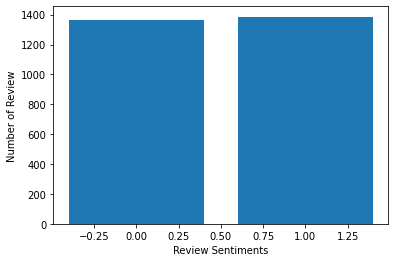

In [11]:
#Prezentacja rozkładu na wykresie
Sentiment_count=all_tweets_df.groupby('sentiment').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['review'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

In [12]:
#Stworzenie kopii tablicy oryginalnej tak by nie stracić oryginalnych danych
df = pd.DataFrame(all_tweets_df)

# Czyszczenie tekstu

In [13]:
#W procesu czyszczenie tekstu stworzono funkcję, która w kompleksowy sposób : 
#zmieni wszystkie litery na małe, usunie tekst w nawiasach kwadratowych, usunie ewentualne linki, 
#znaki specjalne, słowa zawierające numery oraz 
#usunięcia najbardziej popularnych słów w języku angielskim nie noszących za sobą konkretnej treści
#Język angielski wybrano ze względu na język danych 
stop_words = stopwords.words("english")
def text_clean(text):
    '''
    Zmiana tekstu na małe litery, usunięcia tekstu w nawiasach kwadratowych,usunięcie linków,
    usunięcie znaków specjalnych and usunięcie słów zawierających numery.
    '''
    text = text.lower()
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['review'] =df['review'].apply(lambda x : text_clean(x))

In [14]:
sentences=df['review'].tolist()
label=df['sentiment'].tolist()

# Chmura słów

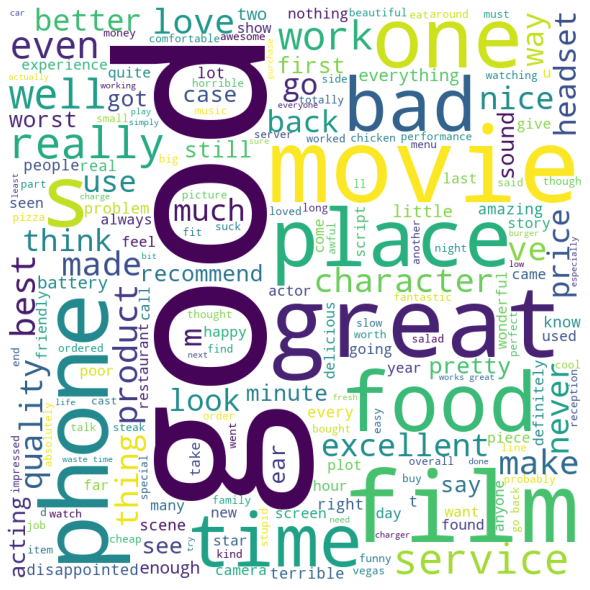

In [15]:
#word cloud czyli tzw chmura słów to wizualizacja częstości występowiania słów.
#Im bardziej częsty term w analizowanym tekście tym większy jest on na wygenerowanym obrazku.
comment_words = ''
for val in df.review: 
      
    # Typowanie każdej wartości na typ string
    val = str(val) 
  
    # dzielimy wartości
    tokens = val.split() 
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(comment_words) 
  
# tworzenie specyficznego wykresu jakim jest Chmura Słów                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Macierz Liczności Słów

In [16]:
#Przygotowanie oraz prezentacja macierzy liczności słów
#Funckja CountVectorizer konwertuje zbiór dokumentów tekstowych na macierz zliczeń tokenów
vec=CountVectorizer()
X=vec.fit_transform(sentences)
count_matrix=pd.DataFrame(X.toarray(),columns=vec.get_feature_names())
print(count_matrix)

      aailiyah  abandoned  abhor  ability  able  abound  about  above  abroad  \
0            0          0      0        0     0       0      0      0       0   
1            0          0      0        0     0       0      0      0       0   
2            0          0      0        0     0       0      0      0       0   
3            0          0      0        0     0       0      0      0       0   
4            0          0      0        0     0       0      0      0       0   
...        ...        ...    ...      ...   ...     ...    ...    ...     ...   
2743         0          0      0        0     0       0      0      0       0   
2744         0          0      0        0     0       0      0      0       0   
2745         0          0      0        0     0       0      0      0       0   
2746         0          0      0        0     0       0      0      0       0   
2747         0          0      0        0     0       0      0      0       0   

      absolute  ...  youtub

# Macierz TfIdf


In [17]:
#Macierz TfIdf jest to jedna z metod obliczania wagi słów w oparciu o liczbę ich wystąpień

In [18]:
#Funkcja TfidfVectorizer konwertuje zbiór nieprzetworzonych dokumentów na macierz TF-IDF.
Tfidf_vector = TfidfVectorizer(max_df=.65, min_df=1, stop_words=None, use_idf=True, norm=None)
transformed_sentences = Tfidf_vector.fit_transform(sentences)

In [19]:
transformed_sentences_as_array = transformed_sentences.toarray()
#wiersz kodu, aby sprawdzić, czy tablica reprezentuje taką samą liczbę dokumentów, jakie mamy na liście
len(transformed_sentences_as_array)

2748

In [20]:
# zapętlenie każdego elementu w tablicy transformed_documents_as_array, 
#używając enumerate do śledzenia bieżącej pozycji elementu
for counter, sentence in enumerate(transformed_sentences_as_array):
    tf_idf_tuples = list(zip(Tfidf_vector.get_feature_names(), sentence))
    one_sentence_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)


In [21]:
#tf-idf to schemat ważenia, który przypisuje każdemu terminowi w dokumencie wagę (score) 
#w oparciu o częstotliwość i odwrotną częstotliwość termów. 
#Zgodnie z metodologią ważniejsze są termy z wyższymi wynikami wagi (score).
one_sentence_as_df

,term,score
0,wound,8.225845
1,drawing,8.225845
2,poured,8.225845
3,salt,7.532698
4,then,7.532698
...,...,...
5021,firehouse,0.000000
5022,fireball,0.000000
5023,fire,0.000000
5024,finished,0.000000


# SVD

In [22]:
# SVD reprezemtuje dokumenty i termy w postaci wektorów 
#Ponieważ dane pochodzą z 3 różnych zbiorów danych, spróbujmy mieć 3 tematy dla naszych danych tekstowych.
model_svd = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122)

model_svd.fit(transformed_sentences)

len(model_svd.components_)

3

In [24]:
#Komponenty modelu SVD to nasze tematy i możemy uzyskać do nich dostęp za pomocą model_svd.components_. 
#Na koniec wydrukujmy kilka najważniejszych słów z każdego z 3 tematów 
#i zobaczmy, jak poradził sobie nasz model
terms = vec.get_feature_names()

for i, comp in enumerate(model_svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
the
 
movie
 
film
 
it
 
one
 
films
 
story
 
Topic 1: 
game
 
this
 
line
 
it
 
screen
 
pg
 
massive
 
Topic 2: 
sucks
 
the
 
two
 
script
 
holes
 
around
 
story
 


# Modele

W projekcie zadecydowano o użyciu 3 modeli : Regresji Logistycznej, Lasów Losowych oraz Naive Bayes
Każdy z 3 modeli nauczono i przetestowana dokładnie na tym samy podziale danych na zbiór testowy i treningowy. Dodatkowo postanowiono sprawdzić czas liczenia każdego z modeli za pomocą biblioteki time.

In [25]:
#Zbiór testowy ustawiono na 33% całej populacji
X_train, X_test, y_train, y_test = train_test_split(sentences, label, test_size=0.33, random_state=1000)

In [26]:
# Przygotowanie danych
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [27]:
#Model - Regresja Logistyczna
start = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
score_lr = lr.score(X_test, y_test)
print("Accuracy:", score_lr)
end = time.time()
print(f"Runtime of the program is {end - start}")

Accuracy: 0.7927232635060639
Runtime of the program is 0.008019447326660156


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
#Model - Las losowy
start = time.time()
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
score_rf =metrics.accuracy_score(y_test, rf.predict(X_test))
print("Accuracy:", score_rf)
end = time.time()
print(f"Runtime of the program is {end - start}")

Accuracy: 0.7243660418963617
Runtime of the program is 0.06890583038330078


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
# Model Naive Bayes
start = time.time()
nb=MultinomialNB(alpha=0.0, class_prior=[0.4, 0.6])
nb.fit(X_train, y_train)
score_NB =metrics.accuracy_score(y_test, nb.predict(X_test))
print("Accuracy:", score_NB)
end = time.time()
print(f"Runtime of the program is {end - start}")

Accuracy: 0.7320837927232635
Runtime of the program is 0.0029754638671875


D:\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [30]:
#Przygotowanie tabeli do zaprezenetowania metryk oceny dopasowania modeli. 
#Do oceny modeli wybrano miary : precision_score, accuracy_score, f1_score, roc_auc, recall_score
results = []
results.append(('LogisticRegression', lr))
results.append(('RandomForestClassifier', rf))
results.append(('MultinomialNB', nb))

precision_score = [] 
accuracy_score = []
f1_score = []
roc_auc = []
recall_score = []

for model, result in results:
    precision_score.append(metrics.precision_score(y_test, result.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, result.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, result.predict(X_test)))
    roc_auc.append(metrics.roc_auc_score(y_test, result.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, result.predict(X_test)))    
    

In [31]:
presentation = {'precision_score': precision_score,
     'accuracy_score' : accuracy_score,
     'f1_score': f1_score,
     'roc_auc_score' : roc_auc,
     'recall_score': recall_score  
    }
df_pres = pd.DataFrame(data=presentation)
df_pres.insert(loc=0, column='Method', value=['LogisticRegression', 'RandomForestClassifier',
                                         'MultinomialNB'])
df_pres

,Method,precision_score,accuracy_score,f1_score,roc_auc_score,recall_score
0,LogisticRegression,0.809013,0.792723,0.800425,0.792760,0.792017
1,RandomForestClassifier,0.747346,0.732084,0.743400,0.731697,0.739496
2,MultinomialNB,0.742204,0.732084,0.746082,0.731148,0.750000


Konkluzja : Po zestawieniu wyników 3 wybranych modeli. Jak możemy zauważyć najlepszym modelem okazała się być Regresja Logistyczna która osiągnęła najlepsza wyniki dopasowania dla każdej z wybranych miar.
Na drugim miejcu postawiłbym na metodę lasów losowych, która okazała się lepsza od metody NB w 4 z 5 miar. Jedyną miarą w której metoda NB okazała się bardziej dopasowana to miara precyzji (precision_score). Jeśli chodzi o szybkość wykonania najlepszy okazał się model NB wyprzedzający Regresję Logistyczną o zaledwie 0.006 sekundy, ta bardzo niewielka różnica patrząc na różnice w miarach dopasowania. Metoda lasów losowych zdecydowania odstawała od reszty reprezentując poziom 0.06 sekundy.
